In [1]:
from trainer import *
import jax
jax.devices()

lovely_jax enabled for enhanced array visualization


[CudaDevice(id=0)]

In [2]:
class NotebookArgs:
    """
    Helper class to mimic argparse.Namespace for Jupyter notebooks.
    Example:
        args = NotebookArgs(
            train_efd="../preclassified_data/energies_forces_dipoles_train.npz",
            train_grid="../preclassified_data/grids_esp_train.npz",
            valid_efd="../preclassified_data/energies_forces_dipoles_valid.npz",
            valid_grid="../preclassified_data/grids_esp_valid.npz",
            batch_size=16,
            epochs=500,
            n_dcm=3,
            verbose=True,
        )
    """

    def __init__(self, **kwargs):
        # Default values — should match argparse defaults
        defaults = dict(
            train_efd=None,
            train_grid=None,
            valid_efd=None,
            valid_grid=None,
            features=64,
            max_degree=2,
            num_iterations=2,
            num_basis_functions=64,
            cutoff=10.0,
            n_dcm=3,
            include_pseudotensors=False,
            batch_size=1000,
            epochs=100,
            learning_rate=0.001,
            esp_weight=10000.0,
            seed=42,
            restart=None,
            name='co2_dcmnet',
            output_dir='./checkpoints',
            print_freq=10,
            save_freq=5,
            verbose=True,
        )

        # Update defaults with user-specified values
        defaults.update(kwargs)

        # Assign all attributes
        for key, val in defaults.items():
            setattr(self, key, val)

    def as_dict(self):
        """Return arguments as a plain dict (useful for logging)."""
        return vars(self)

In [3]:
from trainer import main, load_co2_data


args = NotebookArgs(
    train_efd=Path("../preclassified_data/energies_forces_dipoles_train.npz"),
    train_grid=Path("../preclassified_data/grids_esp_train.npz"),
    valid_efd=Path("../preclassified_data/energies_forces_dipoles_valid.npz"),
    valid_grid=Path("../preclassified_data/grids_esp_valid.npz"),
    output_dir=Path("./output"),
    batch_size=1000,
    epochs=5000,
    learning_rate=5e-4,
)



In [4]:
# Now you can call your functions directly
train_data = load_co2_data(args.train_efd, args.train_grid)
valid_data = load_co2_data(args.valid_efd, args.valid_grid)

# Or if your `main()` function expects args like from argparse:
# 

len(valid_data["R"])

1000

In [5]:
?prepare_datasets
?train_model

Signature:
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    chg_w=0.01,
    restart_params=None,
    ema_decay=0.999,
    num_atoms=60,
    use_grad_clip=False,
    grad_clip_norm=2.0,
    mono_imputation_fn=None,
    distance_weighting=False,
    distance_scale=2.0,
    distance_min=0.5,
)
Docstring:
Train DCMNet model with ESP and monopole losses.

Performs full training loop with validation, logging, and checkpointing.
Uses exponential moving average (EMA) for parameter smoothing and saves
best parameters based on validation loss.

Parameters
----------
key : jax.random.PRNGKey
    Random key for training
model : MessagePassingModel
    DCMNet model instance
train_data : dict
    Training dataset dictionary
valid_data : dict
    Validation dataset dictionary
num_epochs : int
    Number of training epochs
learning_rate : float
    Learning rate for optimization
batch_size : int

In [6]:
from train_charge_predictor import load_charge_data

# # Use only HF level
# R, Z, mono = load_charge_data(csv_file, scheme='Hirshfeld', level='hf')

# # Use only MP2 level
# R, Z, mono = load_charge_data(csv_file, scheme='Hirshfeld', level='mp2')

# # Use all levels (default)
# R, Z, mono = load_charge_data(csv_file, scheme='Hirshfeld', level=None)

In [7]:
#!/usr/bin/env python3
"""
Quick example: Train charge predictor on CO2 data

This script demonstrates how to train the gradient boosting charge predictor
using the CO2 charge data.
"""

from pathlib import Path
from train_charge_predictor import load_charge_data, train_charge_predictor

# Path to your data
data_file = Path("../detailed_charges/df_charges_long.csv")

print("="*70)
print("CO2 Charge Predictor Training Example")
print("="*70)

# Load data - you can choose different schemes: Hirshfeld, VDD, Becke, etc.
# and levels: hf, mp2
print("\nLoading data...")
R, Z, mono = load_charge_data(data_file, scheme='MBIS_raw', level='mp2')

# Train models
print("\nTraining models...")
results = train_charge_predictor(
    R=R,
    Z=Z,
    mono=mono,
    test_size=0.2,
    random_state=42,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    save_path="charge_predictor_MBIS_raw.pkl"
)

print("\n" + "="*70)
print("Training Complete!")
print("="*70)
print(f"\nModel saved to: charge_predictor_hirshfeld.pkl")
print("\nTo use with DCMNet training:")
print("  from train_charge_predictor_usage import create_mono_imputation_fn_from_gb")
print("  mono_imputation_fn = create_mono_imputation_fn_from_gb('charge_predictor_hirshfeld.pkl')")
print("  train_model(..., mono_imputation_fn=mono_imputation_fn)")



CO2 Charge Predictor Training Example

Loading data...
Loaded 27540 rows from ../detailed_charges/df_charges_long.csv
Available schemes: ['Hirshfeld' 'VDD' 'Becke' 'ADCH' 'CHELPG' 'MK' 'CM5' 'MBIS' 'MBIS_raw']
Available levels: ['hf' 'mp2']
Using level: mp2, 13770 rows
Using scheme: MBIS_raw, 1530 rows
Found 510 unique geometry+level combinations

Prepared data:
  R shape: (510, 3, 3)
  Z shape: (510, 3)
  mono shape: (510, 3)

Training models...

Training Gradient Boosting Charge Predictors

Computing molecular features...
Feature matrix shape: (510, 12)

Training model for atom 0 (Z=6)
  Train samples: 408
  Test samples: 102
  Charge range: [0.7880, 1.4690]
  Charge mean: 1.1948, std: 0.1349

  Training...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0149           0.0029            0.17s
         2           0.0114          -0.0006            0.15s
         3           0.0096           0.0039            0.15s
         4           0.0080     

In [8]:
from train_charge_predictor_usage import create_mono_imputation_fn_from_gb
mono_imputation_fn = create_mono_imputation_fn_from_gb('charge_predictor_MBIS_raw.pkl')
mono_imputation_fn?

Signature: mono_imputation_fn(batch: Dict) -> jax.Array
Docstring:
Impute monopoles for a batch.

Parameters
----------
batch : dict
    Batch dictionary containing 'Z', 'R', 'dst_idx', 'src_idx', 'batch_segments'
    
Returns
-------
jnp.ndarray
    Atomic monopoles with shape (batch_size * num_atoms,)
File:      ~/mmml/examples/co2/dcmnet_train/train_charge_predictor_usage.py
Type:      function

In [9]:
train_data["R"][0].shape, train_data["R"][0].shape

((60, 3), (60, 3))

In [10]:
train_data.keys()

dict_keys(['R', 'Z', 'N', 'esp', 'vdw_surface', 'Dxyz', 'E'])

In [11]:
# Initialize JAX random key
key = jax.random.PRNGKey(args.seed)

In [12]:
import sys
import argparse
from pathlib import Path
import numpy as np
import pickle
from typing import Dict, Tuple, Optional, Any, Mapping

# Add mmml to path
# repo_root = Path(__file__).parent / "../../.."
# sys.path.insert(0, str(repo_root.resolve()))

import jax
import jax.numpy as jnp
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
from mmml.dcmnet.dcmnet.training import train_model
# from mmml.dcmnet.dcmnet.data import prepare_datasets

# Validate input files
for fname, fpath in [
    ('Train EFD', args.train_efd),
    ('Train Grid', args.train_grid),
    ('Valid EFD', args.valid_efd),
    ('Valid Grid', args.valid_grid)
]:
    if not fpath.exists():
        print(f"❌ Error: {fname} file not found: {fpath}")
        raise FileNotFoundError(f"{fname} file not found: {fpath}")

print(f"\n📁 Data Files:")
print(f"  Train EFD:  {args.train_efd}")
print(f"  Train Grid: {args.train_grid}")
print(f"  Valid EFD:  {args.valid_efd}")
print(f"  Valid Grid: {args.valid_grid}")

# Setup output directory
args.output_dir.mkdir(exist_ok=True, parents=True)
print(f"  Output: {args.output_dir / args.name}")

# Load data
print(f"\n{'#'*70}")
print("# Loading Data")
print(f"{'#'*70}")

if args.verbose:
    print(f"\nLoading training data...")
train_data_raw = load_co2_data(args.train_efd, args.train_grid)

if args.verbose:
    print(f"Loading validation data...")
valid_data_raw = load_co2_data(args.valid_efd, args.valid_grid)

print(f"\n✅ Data loaded:")
print(f"  Training samples: {len(train_data_raw['R'])}")
print(f"  Validation samples: {len(valid_data_raw['R'])}")
print(f"  Data keys: {list(train_data_raw.keys())}")

# Prepare datasets (convert to DCMnet format with edge lists, etc.)
print(f"\nPreparing datasets (computing edge lists, etc.)...")
# train_data, valid_data = prepare_datasets(
#     train_data_raw,
#     valid_data_raw,
#     num_valid = 
#     # cutoff=args.cutoff,
#     # batch_size=args.batch_size,
# )
train_data = train_data_raw
valid_data = valid_data_raw
print(f"✅ Datasets prepared")
print(f"  Training batches: {len(train_data)}")
print(f"  Validation batches: {len(valid_data)}")

# Build model
print(f"\n{'#'*70}")
print("# Building Model")
print(f"{'#'*70}")

print(f"\nModel hyperparameters:")
print(f"  Features: {args.features}")
print(f"  Max degree: {args.max_degree}")
print(f"  Message passing iterations: {args.num_iterations}")
print(f"  Basis functions: {args.num_basis_functions}")
print(f"  Cutoff: {args.cutoff} Å")
print(f"  Distributed multipoles per atom: {args.n_dcm}")
print(f"  Include pseudotensors: {args.include_pseudotensors}")

model = MessagePassingModel(
    features=args.features,
    max_degree=args.max_degree,
    num_iterations=args.num_iterations,
    num_basis_functions=args.num_basis_functions,
    cutoff=args.cutoff,
    n_dcm=args.n_dcm,
    include_pseudotensors=args.include_pseudotensors,
)

print(f"\n✅ Model created: DCMNet (n_dcm={args.n_dcm})")

# Training setup
print(f"\n{'#'*70}")
print("# Training Setup")
print(f"{'#'*70}")

print(f"\nTraining hyperparameters:")
print(f"  Batch size: {args.batch_size}")
print(f"  Epochs: {args.epochs}")
print(f"  Learning rate: {args.learning_rate}")
print(f"  ESP weight: {args.esp_weight}")
print(f"  Random seed: {args.seed}")

# Load restart parameters if provided
restart_params = None
if args.restart:
    print(f"\n📂 Loading restart checkpoint: {args.restart}")
    with open(args.restart, 'rb') as f:
        restart_params = pickle.load(f)
    print(f"✅ Checkpoint loaded")


📁 Data Files:
  Train EFD:  ../preclassified_data/energies_forces_dipoles_train.npz
  Train Grid: ../preclassified_data/grids_esp_train.npz
  Valid EFD:  ../preclassified_data/energies_forces_dipoles_valid.npz
  Valid Grid: ../preclassified_data/grids_esp_valid.npz
  Output: output/co2_dcmnet

######################################################################
# Loading Data
######################################################################

Loading training data...
Loading validation data...

✅ Data loaded:
  Training samples: 8000
  Validation samples: 1000
  Data keys: ['R', 'Z', 'N', 'esp', 'vdw_surface', 'Dxyz', 'E']

Preparing datasets (computing edge lists, etc.)...
✅ Datasets prepared
  Training batches: 7
  Validation batches: 7

######################################################################
# Building Model
######################################################################

Model hyperparameters:
  Features: 64
  Max degree: 2
  Message passing iterations:

In [13]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    natoms=60,
    clean=False,
    esp_mask=False,
    clip_esp=False,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm

In [14]:
train_data["esp"]

array([[ 0.0052505,  0.0033848,  0.037617 , ...,  0.0093954, -0.023834 ,
         0.0059184],
       [ 0.0043249,  0.0058309, -0.0074244, ..., -0.017754 ,  0.013946 ,
        -0.006544 ],
       [ 0.018399 ,  0.011036 ,  0.0095978, ..., -0.011879 , -0.010322 ,
         0.0057994],
       ...,
       [ 0.042213 ,  0.032696 , -0.011879 , ..., -0.0024751,  0.032268 ,
         0.015244 ],
       [-0.0083788,  0.0076804, -0.010421 , ..., -0.010508 ,  0.0033204,
        -0.0011256],
       [-0.031544 , -0.0094387, -0.0063055, ..., -0.014822 , -0.002533 ,
        -0.0051037]], shape=(8000, 3000), dtype=float32)

In [15]:
train_model?

Signature:
train_model(
    key,
    model,
    train_data,
    valid_data,
    num_epochs,
    learning_rate,
    batch_size,
    writer,
    ndcm,
    esp_w=1.0,
    chg_w=0.01,
    restart_params=None,
    ema_decay=0.999,
    num_atoms=60,
    use_grad_clip=False,
    grad_clip_norm=2.0,
    mono_imputation_fn=None,
    distance_weighting=False,
    distance_scale=2.0,
    distance_min=0.5,
)
Docstring:
Train DCMNet model with ESP and monopole losses.

Performs full training loop with validation, logging, and checkpointing.
Uses exponential moving average (EMA) for parameter smoothing and saves
best parameters based on validation loss.

Parameters
----------
key : jax.random.PRNGKey
    Random key for training
model : MessagePassingModel
    DCMNet model instance
train_data : dict
    Training dataset dictionary
valid_data : dict
    Validation dataset dictionary
num_epochs : int
    Number of training epochs
learning_rate : float
    Learning rate for optimization
batch_size : int

In [16]:
from align_esp_grids import align_esp_grids, sense_check_alignment

# Apply alignment to training and validation data
print("="*70)
print("Aligning ESP Grids")
print("="*70)

print("\nAligning training data...")
train_data = align_esp_grids(train_data, verbose=args.verbose)

print("\nAligning validation data...")
valid_data = align_esp_grids(valid_data, verbose=args.verbose)

# Sense check
print("\n" + "="*70)
print("Sense Check")
print("="*70)
sense_check_alignment(train_data, sample_idx=0, verbose=True)
sense_check_alignment(valid_data, sample_idx=0, verbose=True)

Aligning ESP Grids

Aligning training data...
✅ Aligned ESP grids to molecular reference frames
   Number of samples: 8000

   Sample 0 details:
     Atom COM:        [0.         0.14525378 0.11470596]
     Grid COM before: [[3.25342429 3.24367862 3.3973045 ]
 [3.29037849 3.42968506 3.37285263]
 [3.26749158 3.2349472  3.04755038]
 ...
 [3.23463851 3.24004016 3.27062503]
 [3.23331557 3.19962463 3.1881812 ]
 [3.29324486 3.22379038 3.37600344]]
     Grid COM after:  [2.56091444e-16 1.45253775e-01 1.14705956e-01]
     Offset corrected: [3.25342429 3.09842484 3.28259855] Å

   Sense check:
     Alignment error: 1.122908e-14 Å
     ✓ Alignment verified: grids are centered on atom COM

     ⚠️  Large offset detected: 5.564 Å
        This suggests ESP grids and atoms were in different reference frames.

Aligning validation data...
✅ Aligned ESP grids to molecular reference frames
   Number of samples: 1000

   Sample 0 details:
     Atom COM:        [0.         0.25326187 0.02194556]
     Grid

{'atom_com': array([0.        , 0.25326187, 0.02194556]),
 'grid_com': array([2.56683563e-15, 2.53261870e-01, 2.19455598e-02]),
 'alignment_error': np.float64(1.2058961268398482e-14),
 'offset': array([2.56683563e-15, 1.17128529e-14, 1.28022593e-15]),
 'offset_magnitude': np.float64(1.2058961268398482e-14),
 'is_aligned': np.True_}

In [ ]:
import pandas as pd
# Start training
print(f"\n{'='*70}")
print("STARTING TRAINING")
print(f"{'='*70}\n")

try:
    final_params = train_model(
        key=key,
        model=model,
        train_data=train_data,
        valid_data=valid_data,
        num_epochs=50,
        learning_rate=0.001,
        batch_size=1000,
        esp_w=1000,
        restart_params=pd.read_pickle("best_1000_params.pkl"),
        writer=None,
        chg_w=0,
        ndcm=args.n_dcm,
        mono_imputation_fn=mono_imputation_fn,
        num_atoms = 3,
        use_grad_clip=True,
        grad_clip_norm=100,
        distance_weighting=True,
        # tag=args.name,
        # output_dir=args.output_dir,
        # print_freq=args.print_freq,
    )
    
    # Save final model
    final_path = args.output_dir / f"{args.name}_final.pkl"
    with open(final_path, 'wb') as f:
        pickle.dump(final_params, f)
    
    print(f"\n{'='*70}")
    print("✅ TRAINING COMPLETE!")
    print(f"{'='*70}")
    print(f"\nFinal parameters saved to: {final_path}")
    print(f"\nTo use the trained model:")
    print(f"  from mmml.dcmnet.dcmnet.modules import MessagePassingModel")
    print(f"  import pickle")
    print(f"  ")
    print(f"  # Load parameters")
    print(f"  with open('{final_path}', 'rb') as f:")
    print(f"      params = pickle.load(f)")
    print(f"  ")
    print(f"  # Create model and predict")
    print(f"  model = MessagePassingModel(...)")
    print(f"  mono, dipo = model.apply(params, Z, R, dst_idx, src_idx)")
    print(f"  ")
    print(f"  # Calculate ESP")
    print(f"  from mmml.dcmnet.dcmnet.electrostatics import calc_esp")
    print(f"  esp_pred = calc_esp(mono, dipo, R, vdw_surface)")
    
except KeyboardInterrupt:
    print(f"\n\n⚠️  Training interrupted by user")
    print(f"Checkpoints saved to: {args.output_dir}")
    sys.exit(0)
except Exception as e:
    print(f"\n\n❌ Training failed with error:")
    print(f"  {e}")
    import traceback
    traceback.print_exc()
    sys.exit(1)


STARTING TRAINING

Preparing batches
..................
Training
..................

Epoch   1 Statistics
Metric                         Train           Valid      Difference
--------------------------------------------------------------------------------
loss                    4.149997e+00    1.557146e+03    1.552996e+03
mono_mae                4.124469e-02    4.065245e-02   -5.922392e-04
mono_rmse               1.792418e-01    1.804444e-01    1.202554e-03
mono_mean               3.131000e-03    2.586053e-03   -5.449469e-04
mono_std                7.415346e-03    6.247532e-03   -1.167814e-03
esp_mae                 4.583447e-02    3.113420e-02   -1.470026e-02
esp_rmse                6.777844e-02    5.580584e-02   -1.197260e-02
esp_pred_mean           3.693878e-02    3.036932e-02   -6.569453e-03
esp_pred_std            4.857283e-02    2.362397e-02   -2.494886e-02
esp_error_mean          2.219059e-02    1.558595e-02   -6.604640e-03
esp_error_std           6.404291e-02    5.358516e-02 

In [72]:
valid_data["R"][0]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.042     ],
       [ 0.        ,  0.75978561, -0.97616332],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [73]:
from mmml.dcmnet.dcmnet.modules import MessagePassingModel
import pickle
import e3x
# Load parameters
with open('output/co2_dcmnet_final.pkl', 'rb') as f:
  params = pickle.load(f)

# # Create model and predict
# model = MessagePassingModel()
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(3)
mono, dipo = model.apply(params[0], valid_data["Z"][0], valid_data["R"][0], dst_idx, src_idx)

mono, dipo

(Array[60, 3] n=180 x∈[-0.217, 0.213] μ=0.001 σ=0.029 gpu:0,
 Array[60, 3, 3] n=540 (2.1Kb) x∈[-0.981, 1.045] μ=0.005 σ=0.121 gpu:0)

In [74]:
np.array(mono[:3])

array([[-0.01491767,  0.01612438,  0.01778142],
       [ 0.16924493, -0.04316263, -0.17113067],
       [ 0.21258725, -0.03341345, -0.2169123 ]], dtype=float32)

In [75]:
np.array(mono[:3]), np.array(dipo[:3])

(array([[-0.01491767,  0.01612438,  0.01778142],
        [ 0.16924493, -0.04316263, -0.17113067],
        [ 0.21258725, -0.03341345, -0.2169123 ]], dtype=float32),
 array([[[ 0.0000000e+00, -1.4757870e-04, -3.6481695e-04],
         [ 0.0000000e+00,  5.3340144e-04, -3.8012982e-04],
         [ 0.0000000e+00,  1.6231996e-03, -3.2992912e-03]],
 
        [[ 0.0000000e+00,  7.5148564e-04,  1.0427669e+00],
         [ 0.0000000e+00, -2.3079247e-04,  1.0429245e+00],
         [ 0.0000000e+00, -2.7254981e-04,  1.0453006e+00]],
 
        [[ 0.0000000e+00,  7.5783038e-01, -9.7279841e-01],
         [ 0.0000000e+00,  7.6006317e-01, -9.7690713e-01],
         [ 0.0000000e+00,  7.6224369e-01, -9.8125190e-01]]], dtype=float32))

In [76]:
n_dcm = 3

In [77]:
d = jnp.moveaxis(dipo, -1, -2).reshape(1, 60 * n_dcm, 3)
m = mono.reshape(1, 60 * n_dcm)

In [78]:
calc_esp?

Signature: calc_esp(charge_positions, charge_values, grid_positions)
Docstring: <no docstring>
File:      ~/mmml/mmml/dcmnet/dcmnet/electrostatics.py
Type:      function

In [79]:
import matplotlib.pyplot as plt
from mmml.dcmnet.dcmnet.electrostatics import calc_esp
esp_pred = calc_esp(d[:9], m[:9], valid_data["vdw_surface"][0])

In [80]:
np.array(esp_pred)

array([0.04316881, 0.02435044, 0.02423589, ..., 0.02459976, 0.02940793,
       0.0216679 ], shape=(3000,), dtype=float32)

In [81]:
valid_data["esp"][0] 

array([ 0.0037571, -0.011659 ,  0.010436 , ..., -0.010691 ,  0.0091256,
        0.0044662], shape=(3000,), dtype=float32)

In [ ]:
plt.scatter(np.array(esp_pred), valid_data["esp"][0] )
# plt.xlim(-0.1, 0.1)
# plt.ylim(-0.1, 0.1)

In [83]:
import numpy as np
import pickle

esp = valid_data["esp"][0]         # (N,)
grid = valid_data["vdw_surface"][0]     # (N, 3) in Angstrom
R =  valid_data["R"][0]          # (M, 3)
Z = valid_data["Z"][0]               # (M,)

# Define a cube (rectilinear) grid around the molecule
pad = 4.0  # Angstrom padding
mins = np.min(R, axis=0) - pad
maxs = np.max(R, axis=0) + pad
nx, ny, nz = 40, 40, 40
xs = np.linspace(mins[0], maxs[0], nx)
ys = np.linspace(mins[1], maxs[1], ny)
zs = np.linspace(mins[2], maxs[2], nz)
X, Y, Zz = np.meshgrid(xs, ys, zs, indexing="ij")
cube_points = np.stack([X, Y, Zz], axis=-1).reshape(-1, 3)

# Interpolate scattered ESP onto the rectilinear grid (nearest-neighbor)
from scipy.spatial import cKDTree
tree = cKDTree(grid)
_, idx = tree.query(cube_points, k=1)
cube_values = esp[idx].reshape(nx, ny, nz)

def write_cube(path, atoms_Z, atoms_R, origin, axes, values):
    # values must be shaped (nx, ny, nz)
    nx, ny, nz = values.shape
    ax, ay, az = axes  # each is (3,) box vector in Angstrom / count
    with open(path, "w") as f:
        f.write("ESP cube generated by mmml\n")
        f.write("ESP on a rectilinear grid\n")
        f.write(f"{len(atoms_Z):4d} {origin[0]:12.6f} {origin[1]:12.6f} {origin[2]:12.6f}\n")
        f.write(f"{nx:4d} {ax[0]:12.6f} {ax[1]:12.6f} {ax[2]:12.6f}\n")
        f.write(f"{ny:4d} {ay[0]:12.6f} {ay[1]:12.6f} {ay[2]:12.6f}\n")
        f.write(f"{nz:4d} {az[0]:12.6f} {az[1]:12.6f} {az[2]:12.6f}\n")
        for Zq, Rq in zip(atoms_Z, atoms_R):
            f.write(f"{int(Zq):4d} {float(Zq):12.6f} {Rq[0]:12.6f} {Rq[1]:12.6f} {Rq[2]:12.6f}\n")
        # Write voxel data, 6 values per line
        count = 0
        for i in range(nx):
            for j in range(ny):
                line_vals = []
                for k in range(nz):
                    line_vals.append(f"{values[i, j, k]:13.5e}")
                    count += 1
                    if len(line_vals) == 6:
                        f.write(" ".join(line_vals) + "\n")
                        line_vals = []
                if line_vals:
                    f.write(" ".join(line_vals) + "\n")

# Build cube axes from box lengths
ax = np.array([xs[1]-xs[0], 0.0, 0.0])
ay = np.array([0.0, ys[1]-ys[0], 0.0])
az = np.array([0.0, 0.0, zs[1]-zs[0]])
write_cube(
    "esp.cube",
    atoms_Z=Z,
    atoms_R=R,
    origin=np.array([xs[0], ys[0], zs[0]]),
    axes=(ax, ay, az),
    values=cube_values,
)

In [84]:
indices = abs(valid_data["esp"][0]) < 0.06

In [85]:
VMAX = 0.06

In [86]:
import matplotlib.pyplot as plt

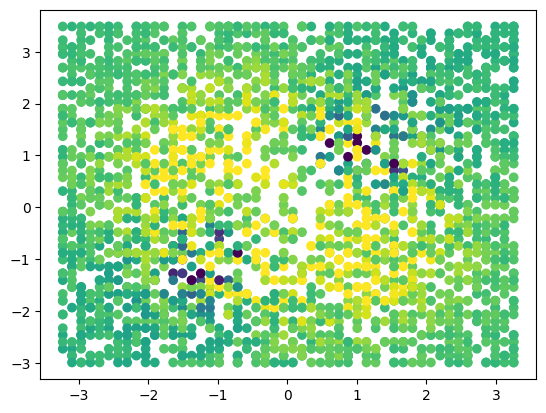

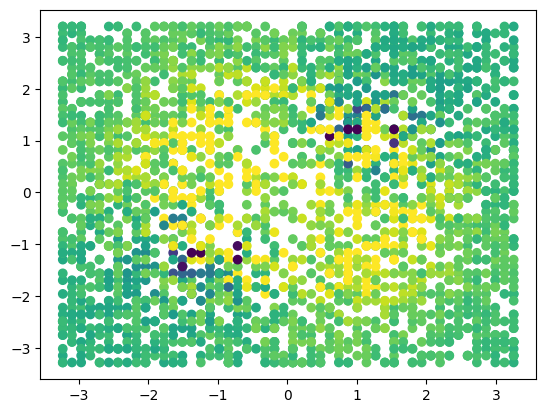

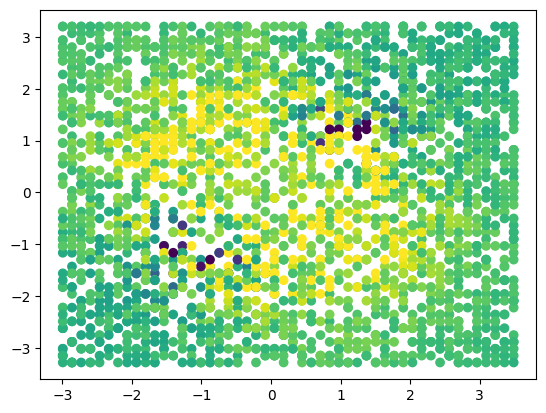

In [87]:
VDW = valid_data["vdw_surface"][0]
X,Y,Z = VDW.T
plt.scatter(X[indices],Y[indices], c=esp_pred[indices], vmin=-VMAX, vmax=VMAX)
plt.show()
plt.scatter(X[indices],Z[indices], c=esp_pred[indices], vmin=-VMAX, vmax=VMAX)
plt.show()
plt.scatter(Y[indices],Z[indices], c=esp_pred[indices], vmin=-VMAX, vmax=VMAX)

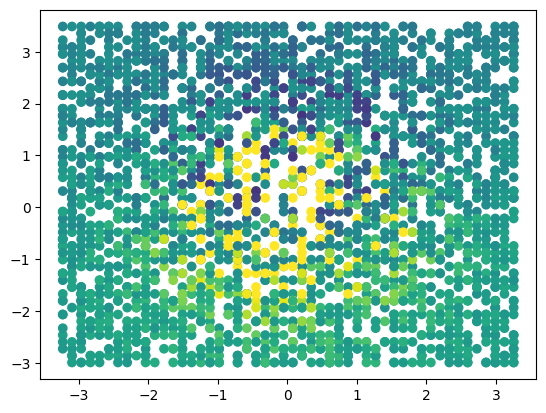

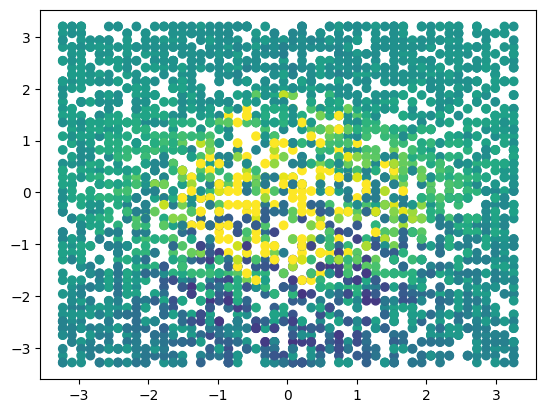

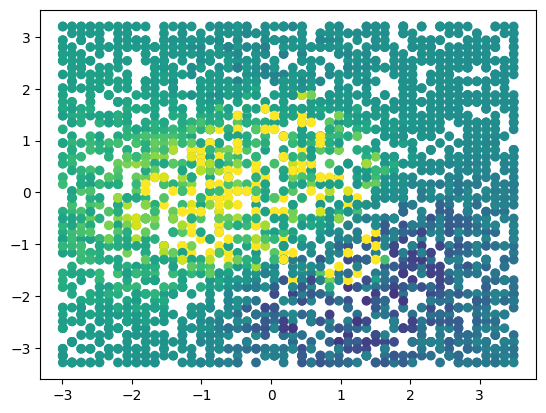

In [88]:
VDW = valid_data["vdw_surface"][0]
X,Y,Z = VDW.T
plt.scatter(X,Y, c= valid_data["esp"][0], vmin=-VMAX, vmax=VMAX)
plt.show()
plt.scatter(X,Z, c= valid_data["esp"][0], vmin=-VMAX, vmax=VMAX)
plt.show()
plt.scatter(Y,Z, c= valid_data["esp"][0], vmin=-VMAX, vmax=VMAX)

In [89]:
params

({'params': {'Dense_0': {'0+': {'bias': Array[64] x∈[-0.008, 0.008] μ=-0.000 σ=0.003 gpu:0,
     'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.289, 0.306] μ=-0.005 σ=0.126 gpu:0},
    '1-': {'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.371, 0.461] μ=-0.000 σ=0.134 gpu:0},
    '2+': {'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.453, 0.421] μ=0.003 σ=0.135 gpu:0}},
   'Dense_1': {'0+': {'bias': Array[64] x∈[-0.006, 0.007] μ=7.653e-05 σ=0.003 gpu:0,
     'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.292, 0.294] μ=-0.001 σ=0.124 gpu:0},
    '1-': {'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.431, 0.480] μ=0.002 σ=0.134 gpu:0},
    '2+': {'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.375, 0.399] μ=0.001 σ=0.134 gpu:0}},
   'Dense_2': {'0+': {'bias': Array[64] x∈[-0.006, 0.011] μ=-0.001 σ=0.003 gpu:0,
     'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.294, 0.293] μ=-0.000 σ=0.124 gpu:0},
    '1-': {'kernel': Array[64, 64] n=4096 (16Kb) x∈[-0.346, 0.326] μ=-0.002 σ=0.129 gpu:0},
    '2+': {'kernel': Arr

In [45]:
prepare_datasets?

Signature:
prepare_datasets(
    key,
    num_train,
    num_valid,
    filename,
    natoms=60,
    clean=False,
    esp_mask=False,
    clip_esp=False,
)
Docstring:
Prepare datasets for training and validation.

Wrapper function that calls prepare_multiple_datasets and then
creates train/validation splits and dictionaries.

Parameters
----------
key : jax.random.PRNGKey
    Random key for dataset shuffling
num_train : int
    Number of training samples
num_valid : int
    Number of validation samples
filename : str or list
    Filename(s) to load datasets from
clean : bool, optional
    Whether to filter failed calculations, by default False
esp_mask : bool, optional
    Whether to create ESP masks, by default False
clip_esp : bool, optional
    Whether to clip ESP to first 1000 points, by default False
natoms : int, optional
    Maximum number of atoms per system, by default 60

Returns
-------
tuple
    A tuple containing train_data and valid_data dictionaries
File:      ~/mmml/mmm